Uploading and Unzipping Dataset

In [ ]:
from google.colab import files
import zipfile
import os

# Uploading ZIP
uploaded = files.upload()

# Unzipping the uploaded file
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        zip_ref = zipfile.ZipFile(filename, 'r')
        zip_ref.extractall("/content")
        zip_ref.close()
        print(f"Extracted archive (7) to /content")


Saving archive (7).zip to archive (7).zip
Extracted archive (7).zip to /content


Folder Structure

In [ ]:
# Checking folder existence
import os

extracted_path = "/content/Cropped Classified"
if os.path.exists(extracted_path):
    print("Extracted folder structure:")
    for dirpath, dirnames, filenames in os.walk(extracted_path):
        print(f"{dirpath} - {len(filenames)} files")
else:
    print("Folder not found. Please check your ZIP content.")


Extracted folder structure:
/content/Cropped Classified - 0 files
/content/Cropped Classified/01 Neutrophil - 319 files
/content/Cropped Classified/04 Eosinophil - 82 files
/content/Cropped Classified/05 Basophil - 20 files
/content/Cropped Classified/02 Lymphocyte - 905 files
/content/Cropped Classified/03 Monocyte - 82 files


🧠 Loading Dataset and Defining Data Pipeline

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Dataset constants
DATASET_PATH = "/content/Cropped Classified"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

# Load training/validation datasets
train_ds_raw = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds_raw = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names = train_ds_raw.class_names
print("Class Names:", class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.prefetch(buffer_size=AUTOTUNE)


Found 1408 files belonging to 5 classes.
Using 1127 files for training.
Found 1408 files belonging to 5 classes.
Using 281 files for validation.
Class Names: ['01 Neutrophil', '02 Lymphocyte', '03 Monocyte', '04 Eosinophil', '05 Basophil']


Building the Model using ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Loading pre-trained ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freezing base layers

# Adding classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compiling model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training the Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Saving best model
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)

# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb]
)


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5576 - loss: 1.4620

36/36 ━━━━━━━━━━━━━━━━━━━━ 278s 7s/step - accuracy: 0.5591 - loss: 1.4547 - val_accuracy: 0.7011 - val_loss: 0.8707
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7507 - loss: 0.7927

36/36 ━━━━━━━━━━━━━━━━━━━━ 316s 7s/step - accuracy: 0.7503 - loss: 0.7932 - val_accuracy: 0.7295 - val_loss: 0.8168
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - accuracy: 0.7486 - loss: 0.7029 - val_accuracy: 0.6512 - val_loss: 0.9673
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7626 - loss: 0.6874

36/36 ━━━━━━━━━━━━━━━━━━━━ 324s 7s/step - accuracy: 0.7627 - loss: 0.6871 - val_accuracy: 0.7687 - val_loss: 0.7266
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8088 - loss: 0.5833

36/36 ━━━━━━━━━━━━━━━━━━━━ 260s 7s/step - accuracy: 0.8086 - loss: 0.5842 - val_accuracy: 0.7829 - val_loss: 0.6958
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 263s 7s/step - accuracy: 0.8162 - loss: 0.5581 - val_accuracy: 0.7936 - val_loss: 0.7196
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 225s 6s/step - accuracy: 0.8330 - loss: 0.4982 - val_accuracy: 0.7865 - val_loss: 0.7055
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 297s 7s/step - accuracy: 0.8396 - loss: 0.5002 - val_accuracy: 0.7900 - val_loss: 0.7699
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - accuracy: 0.8410 - loss: 0.5087 - val_accuracy: 0.8007 - val_loss: 0.7091
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step - accuracy: 0.8629 - loss: 0.4271 - val_accuracy: 0.7651 - val_loss: 0.7125


Evaluating the Model

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Loading best model
model = tf.keras.models.load_model("best_model.h5")

# Evaluation on validation set
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc * 100:.2f}%")

# Prediction and classification
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.7248 - loss: 0.7543
Validation Accuracy: 78.29%
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
               precision    recall  f1-score   support

01 Neutrophil       0.84      0.62      0.72        61
02 Lymphocyte       0.78      0.98      0.87       178
  03 Monocyte       1.00      0.05      0.09        22
04 Eosinophil       0.60      0.35      0.44        17
  05 Basophil       0.00      0.00      0.00         3

     accuracy                           0.78       281
    macro avg       0.64      0.40      0.42       281
 weighted avg       0.79      0.78      0.74       281



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Plot Accuracy and Loss

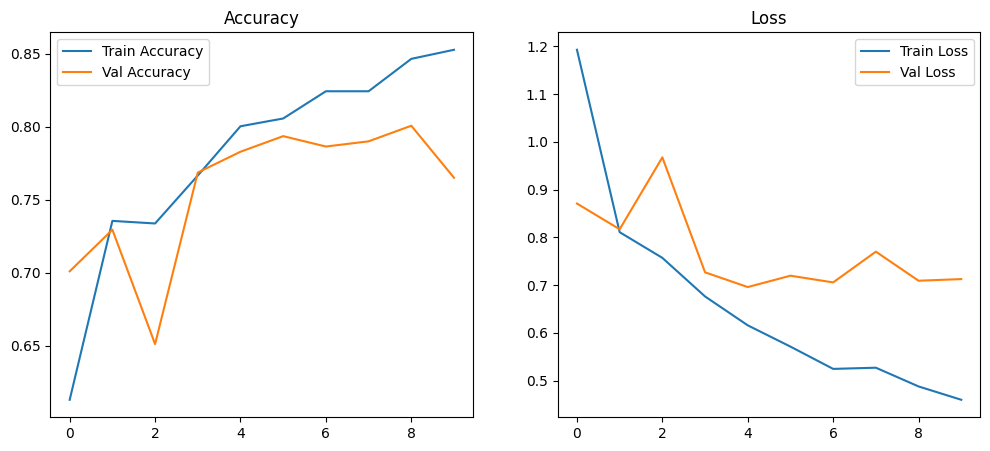

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()


Visualizing Sample Images from Training Dataset

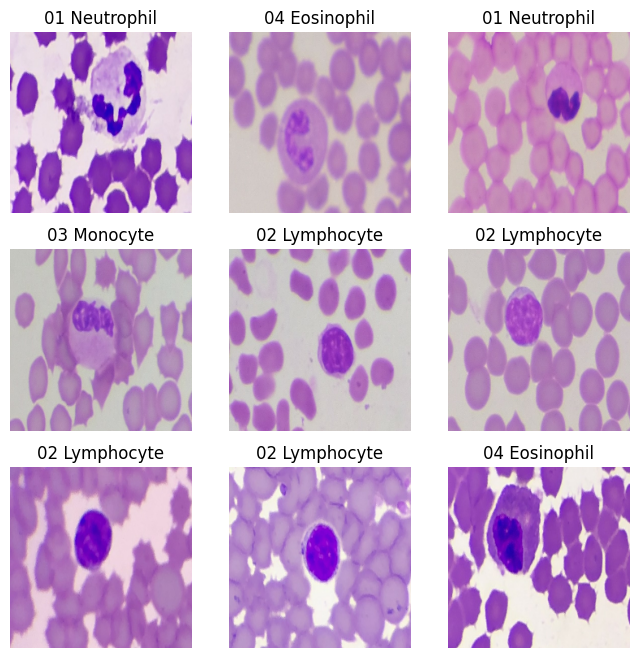

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

show_sample_images(train_ds_raw, class_names)


Visualizing Model Predictions vs Actual Labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


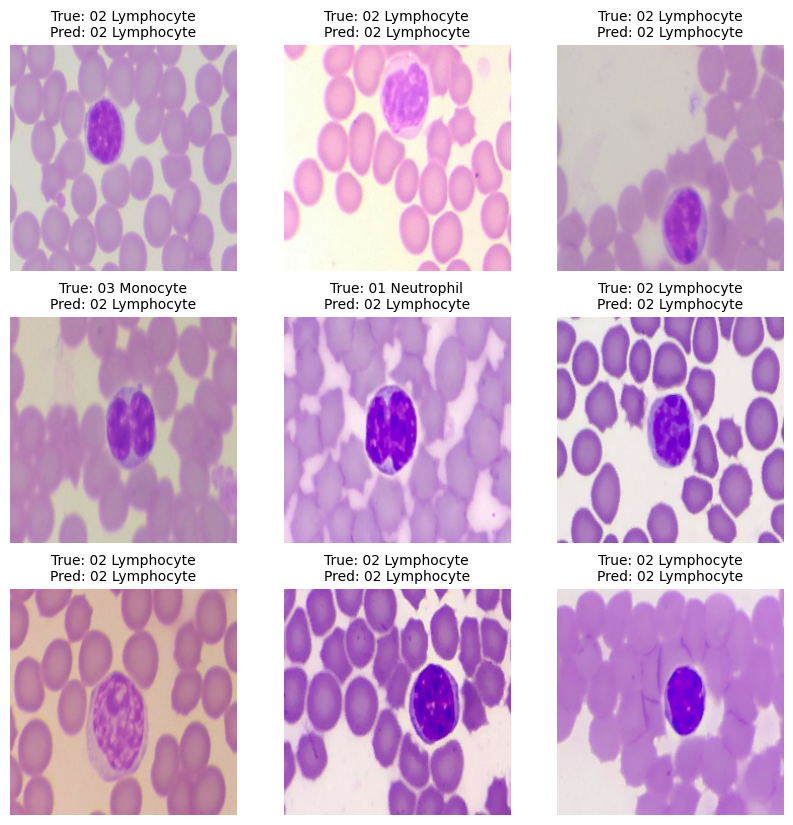

In [ ]:
import numpy as np

def show_predictions(dataset, model, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_labels = tf.argmax(preds, axis=1)

        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[labels[i]]
            pred_label = class_names[pred_labels[i]]
            plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
            plt.axis("off")

show_predictions(val_ds, model, class_names)


Confusion Matrix Plot

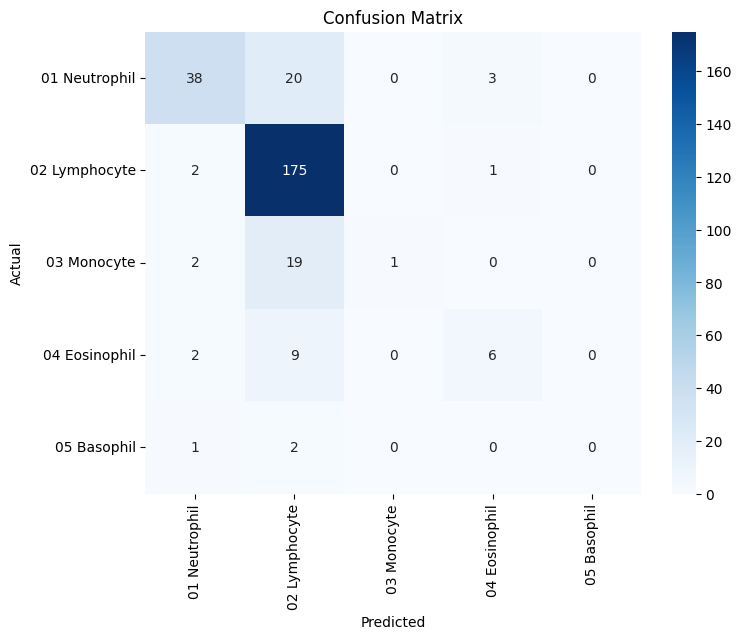

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Visualizing Class Distribution in the Dataset

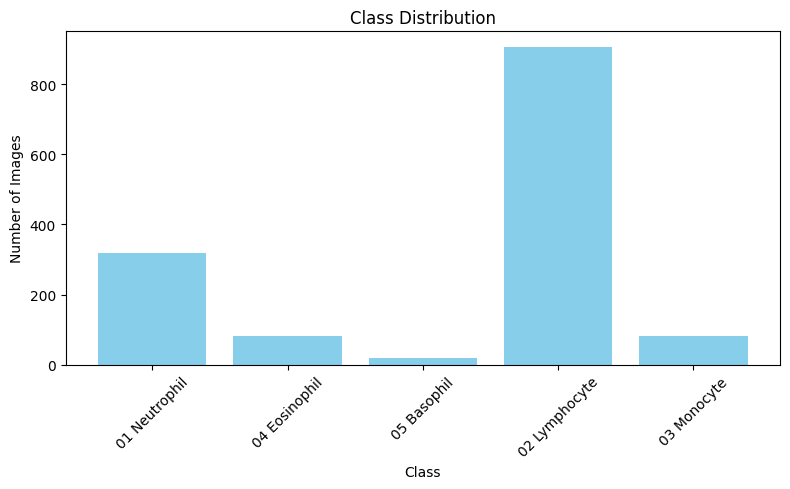

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(base_path):
    class_counts = {}
    for class_name in os.listdir(base_path):
        class_dir = os.path.join(base_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count

    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution("/content/Cropped Classified")


Visualizing Misclassified Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


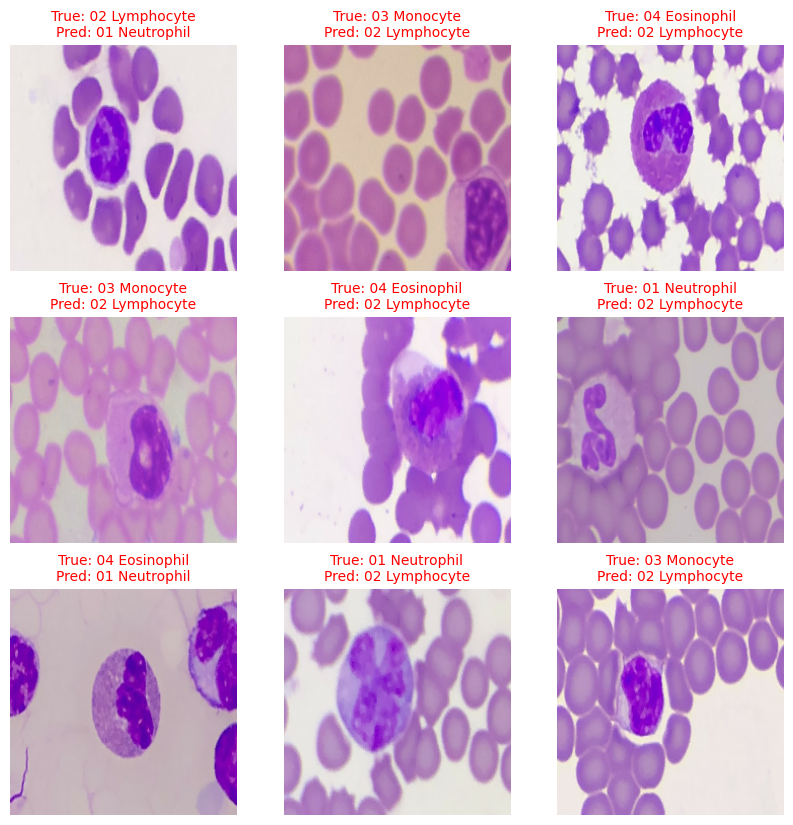

Total Misclassified Images: 9


In [ ]:
def show_misclassified_images(dataset, model, class_names, num_images=9):
    import matplotlib.pyplot as plt
    import tensorflow as tf

    plt.figure(figsize=(10, 10))
    shown = 0

    for images, labels in dataset:
        preds = model.predict(images)
        pred_labels = tf.argmax(preds, axis=1)

        # Ensure both tensors are the same dtype
        pred_labels = tf.cast(pred_labels, tf.int64)
        labels = tf.cast(labels, tf.int64)

        for i in range(len(labels)):
            if pred_labels[i] != labels[i]:  # ✅ FIXED: Added colon here
                if shown < num_images:
                    ax = plt.subplot(3, 3, shown + 1)
                    plt.imshow(images[i].numpy().astype("uint8"))
                    true_label = class_names[labels[i]]
                    pred_label = class_names[pred_labels[i]]
                    plt.title(f"True: {true_label}\nPred: {pred_label}", color="red", fontsize=10)
                    plt.axis("off")
                    shown += 1

        if shown >= num_images:
            break

    plt.show()
    print(f"Total Misclassified Images: {shown}")

show_misclassified_images(val_ds, model, class_names)

Visualizing Per-Class Accuracy

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def per_class_accuracy(y_true, y_pred, class_names):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        idx = y_true == i
        acc = accuracy_score(y_true[idx], y_pred[idx])
        print(f"{class_name}: {acc:.2%}")

per_class_accuracy(y_true, y_pred, class_names)


Per-Class Accuracy:
01 Neutrophil: 62.30%
02 Lymphocyte: 98.31%
03 Monocyte: 4.55%
04 Eosinophil: 35.29%
05 Basophil: 0.00%


 Plotting Multiclass ROC Curve for Each Class

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


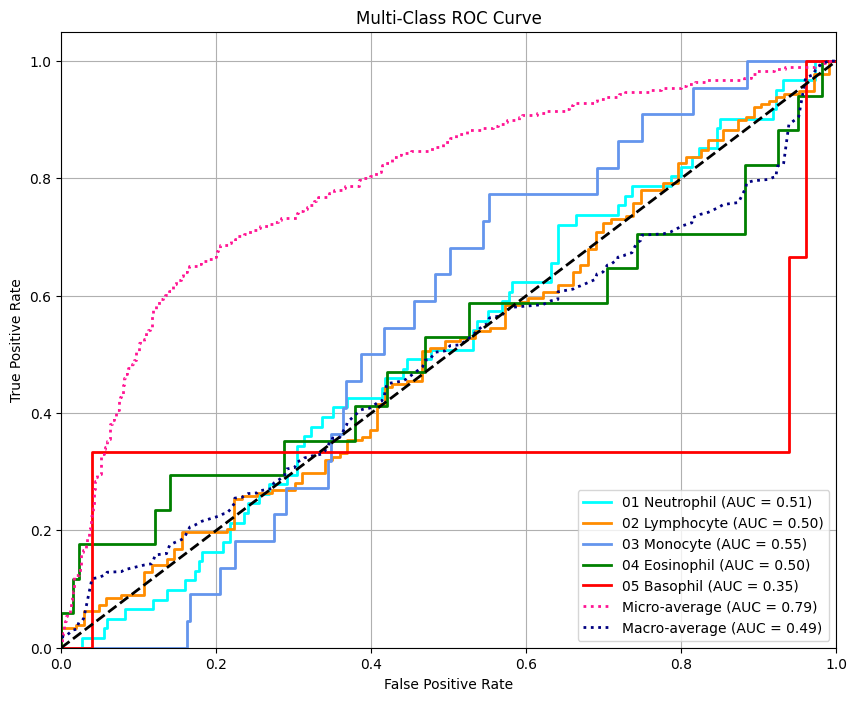

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# Binarizing the true labels
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
n_classes = len(class_names)

# Predicted probabilities
y_pred_probs = []
for images, _ in val_ds:
    preds = model.predict(images)
    y_pred_probs.append(preds)

# Combining all predictions
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

# Computing ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Computing micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Computing macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting everything
plt.figure(figsize=(10, 8))

# Plotting ROC for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plotting micro and macro
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle=':', linewidth=2)

# Plotting baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)

# Saving figure to file
plt.savefig("roc_curve.png", dpi=300)
plt.show()
